# Forecasting Shrimp Price (Mexico) - Data From US Department of Commerce
## Context

Description: Shrimp , (Mexico), west coast, frozen, white, No. 1, shell-on, headless, 26 to 30 count per pound, wholesale price at New York.
Content

Top commodity suppliers.
Acknowledgements

https://www.indexmundi.com/commodities/?commodity=shrimp&months=120
Source: US Department of Commerce, NOAA, Fishery Market News; World Bank.
Inspiration

Agricultural production statistics.

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

In [330]:
df = pd.read_csv('shrimp-prices.csv',parse_dates=['Month'],index_col = 'Month')
df = df['Price']

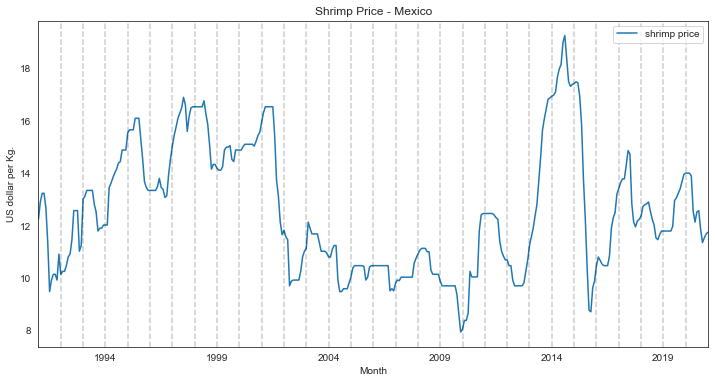

In [331]:
start_year = df.index[0].year
end_year = df.index[-1].year
plt.figure(figsize=(12,6))
sns.set_style('white')
df.plot(label='shrimp price')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price - Mexico')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

# Start Date 2002

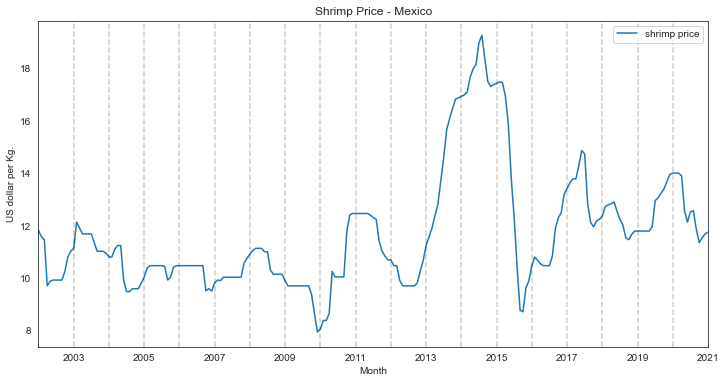

In [332]:
ts = df["2002":] 
start_year = ts.index[0].year
end_year = ts.index[-1].year

# plot data from 2002 to 2021
plt.figure(figsize=(12,6))
sns.set_style('white')
ts.plot(label='shrimp price')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price - Mexico')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

## Split train set and Validation set

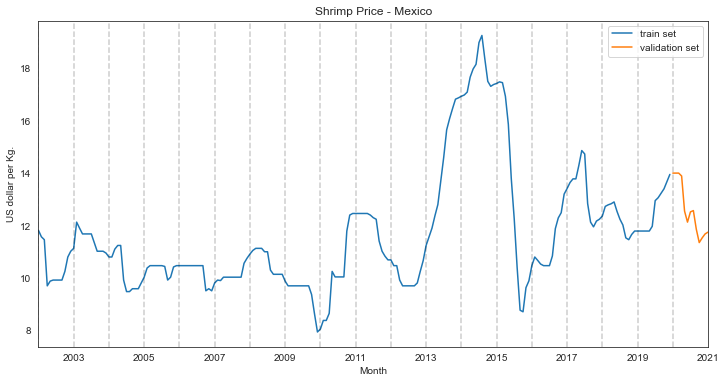

In [333]:
train_ts = ts['2002':'2019'] 
val_ts = ts['2020':]

# plot data from 2002 to 2021
plt.figure(figsize=(12,6))
sns.set_style('white')
train_ts.plot(label='train set')
val_ts.plot(label='validation set')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price - Mexico')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

In [334]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [335]:
def plot_acf_pacf(ts):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(ts,lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(ts,lags=40, ax=ax2)
    plt.show()

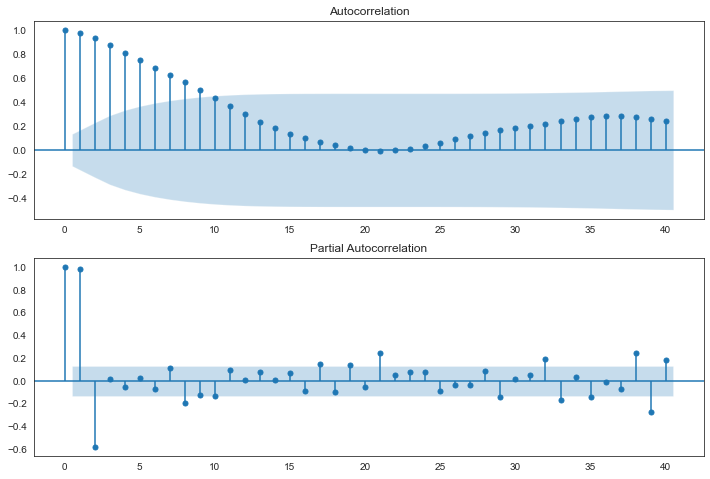

In [336]:
plot_acf_pacf(train_ts)

not stationary because acf exponentially decays

In [337]:
def adfuller_test(ts):
    result = adfuller(ts)
    labels = ['ADF test Statistics','p-value','#Lags used', 'Number of Observation Used']
    for value,label in zip(result,labels):
        print(label,':',value)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary')

In [338]:
adfuller_test(train_ts)

ADF test Statistics : -2.6212116249076116
p-value : 0.08869202170223534
#Lags used : 1
Number of Observation Used : 214
weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary


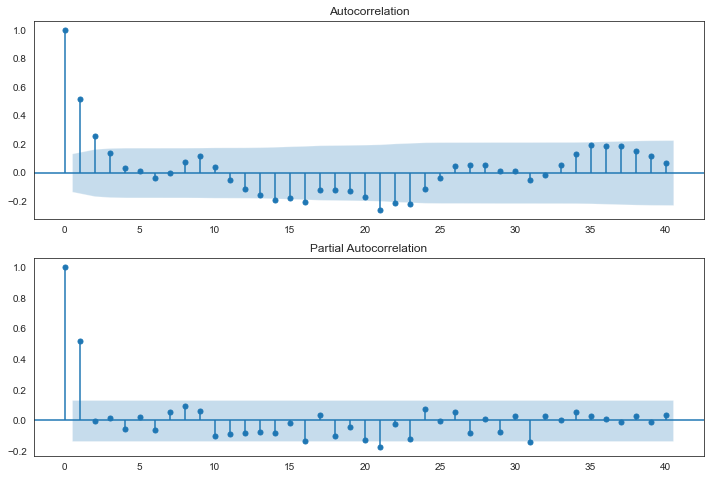

In [339]:
train_ts_diff = train_ts.diff()[1:]
plot_acf_pacf(train_ts_diff)

In [340]:
adfuller_test(train_ts_diff)

ADF test Statistics : -8.257543759325428
p-value : 5.188089292490526e-13
#Lags used : 0
Number of Observation Used : 214
Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary


- train_ts_diff is a stationary
- Select base model ARIMA(1,1,0)

In [341]:
ARIMA110 = ARIMA(train_ts,order=(1,1,0))
ARIMA110_fit = ARIMA110.fit(disp=0)
print(ARIMA110_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  215
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -115.797
Method:                       css-mle   S.D. of innovations              0.414
Date:                Mon, 10 Jan 2022   AIC                            237.593
Time:                        10:47:38   BIC                            247.705
Sample:                    02-01-2002   HQIC                           241.679
                         - 12-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0099      0.058      0.172      0.863      -0.103       0.123
ar.L1.D.Price     0.5116      0.058      8.763      0.000       0.397       0.626
                                    Root

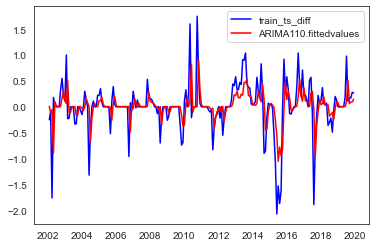

In [342]:
plt.plot(train_ts_diff,color='blue',label='train_ts_diff')
plt.plot(ARIMA110_fit.fittedvalues,color='red',label='ARIMA110.fittedvalues')
plt.legend()
plt.show()

In [343]:
predictions_ARIMA_diff = pd.Series(ARIMA110_fit.predict(start= 1,end=215),copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff.head())
print(predictions_ARIMA_diff.tail())
print(predictions_ARIMA_diff_cumsum.head())
print(predictions_ARIMA_diff_cumsum.tail())

2002-02-01    0.009908
2002-03-01   -0.123055
2002-04-01   -0.051434
2002-05-01   -0.895538
2002-06-01    0.096923
Freq: MS, dtype: float64
2019-08-01    0.506185
2019-09-01    0.061113
2019-10-01    0.091807
2019-11-01    0.091807
2019-12-01    0.148081
Freq: MS, dtype: float64
2002-02-01    0.009908
2002-03-01   -0.113147
2002-04-01   -0.164582
2002-05-01   -1.060119
2002-06-01   -0.963196
Freq: MS, dtype: float64
2019-08-01    1.604228
2019-09-01    1.665341
2019-10-01    1.757149
2019-11-01    1.848956
2019-12-01    1.997037
Freq: MS, dtype: float64


In [344]:
predictions_ARIMA = pd.Series(train_ts.iloc[0], index=train_ts.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA

2002-01-01    11.820000
2002-02-01    11.829908
2002-03-01    11.706853
2002-04-01    11.655418
2002-05-01    10.759881
                ...    
2019-08-01    13.424228
2019-09-01    13.485341
2019-10-01    13.577149
2019-11-01    13.668956
2019-12-01    13.817037
Length: 216, dtype: float64

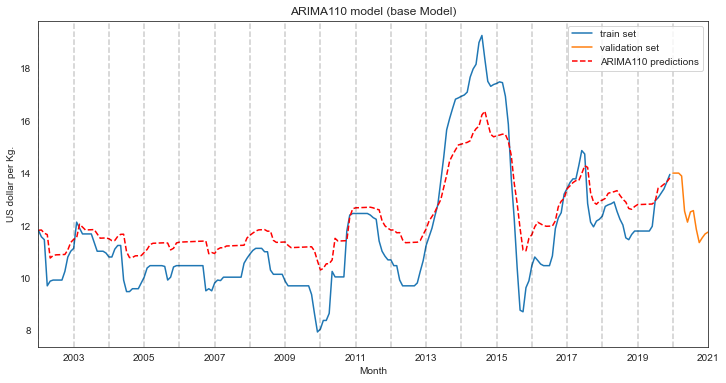

In [345]:
plt.figure(figsize=(12,6))
sns.set_style('white')
train_ts.plot(label='train set')
val_ts.plot(label='validation set')
predictions_ARIMA.plot(label='ARIMA110 predictions',color='red',linestyle='--')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)

plt.title('ARIMA110 model (base Model)')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

## Check aic score whether better model exist

In [346]:
import itertools
p=d=q =range(0,3)
pdq = list(itertools.product(p,d,q))

In [347]:
for param in pdq:
    try:
        mod = SARIMAX(train_ts,order=param,seasonal_order=(0,0,0,0))
        results = mod.fit()
        print("ARIMA {} : AIC {}".format(param,results.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC 1683.7390518898474
ARIMA (0, 0, 1) : AIC 1396.523931134932
ARIMA (0, 0, 2) : AIC 1132.1910676502307
ARIMA (0, 1, 0) : AIC 299.1180552152907
ARIMA (0, 1, 1) : AIC 246.39688301629775
ARIMA (0, 1, 2) : AIC 241.75250476397957
ARIMA (0, 2, 0) : AIC 292.601219172568
ARIMA (0, 2, 1) : AIC 271.9770387975335
ARIMA (0, 2, 2) : AIC 255.6394564828224
ARIMA (1, 0, 0) : AIC 308.98777899522827
ARIMA (1, 0, 1) : AIC 256.2341564047557
ARIMA (1, 0, 2) : AIC 251.54080529644278
ARIMA (1, 1, 0) : AIC 235.62274181857882
ARIMA (1, 1, 1) : AIC 237.61278299391788
ARIMA (1, 1, 2) : AIC 239.52315441960872
ARIMA (1, 2, 0) : AIC 282.1416010065693
ARIMA (1, 2, 1) : AIC 241.44817470549356
ARIMA (1, 2, 2) : AIC 243.44701215494382
ARIMA (2, 0, 0) : AIC 245.48806040601846
ARIMA (2, 0, 1) : AIC 247.34373483528543
ARIMA (2, 0, 2) : AIC 249.2525753794933
ARIMA (2, 1, 0) : AIC 237.61359927223847
ARIMA (2, 1, 1) : AIC 238.06804186740078
ARIMA (2, 1, 2) : AIC 239.65995124306875
ARIMA (2, 2, 0) : AIC 273

ARIMA(1,1,0) provides lowest aic score

In [348]:
mod = SARIMAX(train_ts,order=(1,1,0),seasonal_order=(0,0,0,0))
mod_fit = mod.fit()
print(mod_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5118      0.039     12.994      0.000       0.435       0.589
sigma2         0.1717      0.009     19.997      0.000       0.155       0.189


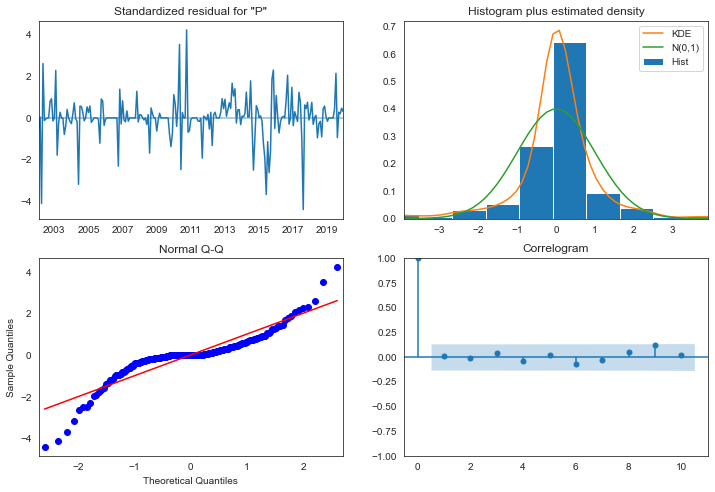

In [349]:
mod_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [350]:
prediction = mod_fit.get_prediction(start=pd.to_datetime('2020-01-01'),end=pd.to_datetime('2020-12-01'))
pred = prediction.conf_int()
pred['mean'] = prediction.predicted_mean
pred['actual'] = val_ts

In [351]:
pred

,lower Price,upper Price,mean,actual
2020-01-01,13.276034,14.900329,14.088182,14.00
2020-02-01,12.686808,15.630994,14.158901,14.00
2020-03-01,12.135450,16.254738,14.195094,14.00
2020-04-01,11.636272,16.790962,14.213617,13.89
2020-05-01,11.186810,17.259384,14.223097,12.55
2020-06-01,10.780091,17.675806,14.227948,12.13
2020-07-01,10.408874,18.051988,14.230431,12.52
2020-08-01,10.066903,18.396501,14.231702,12.57
2020-09-01,9.749109,18.715596,14.232352,11.86
2020-10-01,9.451484,19.013887,14.232685,11.35


# ARIMA (1,1,0) 

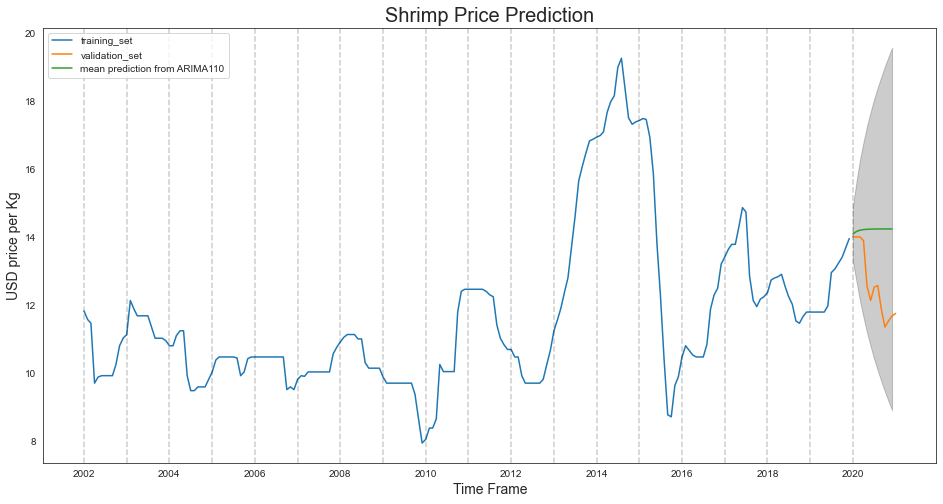

In [352]:
# Start date and End date


# setting figure
plt.figure(figsize=(16,8))
sns.set_style('white')
# plot data
plt.plot(train_ts.index,train_ts,label='training_set')
plt.plot(val_ts.index,val_ts,label='validation_set')
plt.plot(pred.index,pred['mean'], label= 'mean prediction from ARIMA110')
plt.fill_between(pred.index,pred.loc[:,'lower Price'],pred.loc[:,'upper Price'],color='k',alpha=0.2)
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)

# chart decoration
plt.title('Shrimp Price Prediction',fontsize=20)
plt.ylabel('USD price per Kg',fontsize=14)
plt.xlabel('Time Frame',fontsize=14)
plt.legend(loc='upper left')
plt.show()

# Improve prediction with rolling forecast technique

In [353]:
train_end = datetime(2019,12,1)
test_end = datetime(2020,12,1)
# train_data = train_data.milk_production
train_data = ts[:train_end]

In [354]:
my_order = (1,1,0)
my_seasonal_order = (0,0,0,0)
prediction_rolling = []

for train_end in val_ts.index:
    train_data_roll = ts[:train_end-timedelta(days=1)]
    model_roll = SARIMAX(train_data_roll, order = my_order, seasonal_order = my_seasonal_order)
    model_roll_fit = model_roll.fit()
    prediction = model_roll_fit.get_prediction(start=1)
    prediction_rolling_df = prediction.conf_int()

In [355]:
prediction_rolling_df['mean'] = prediction.predicted_mean

In [356]:
prediction_rolling_df

,lower Price,upper Price,mean
2002-02-01,10.873247,12.766755,11.820001
2002-03-01,10.624684,12.265998,11.445341
2002-04-01,10.584493,12.225807,11.405150
2002-05-01,8.001743,9.643058,8.822400
2002-06-01,9.149097,10.790412,9.969754
...,...,...,...
2020-08-01,11.893811,13.535125,12.714468
2020-09-01,11.774275,13.415589,12.594932
2020-10-01,10.685311,12.326626,11.505968
2020-11-01,10.275038,11.916353,11.095696


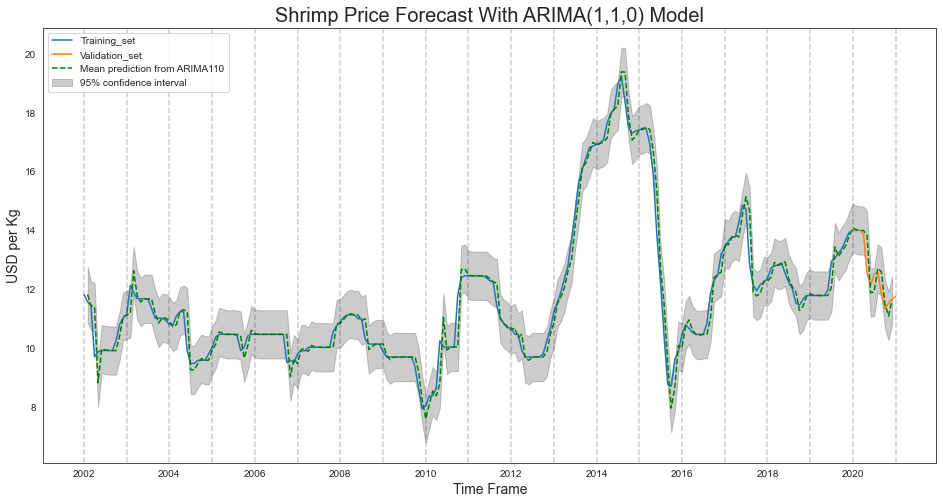

In [357]:
# Start date and End date
start_year = ts.index[0].year
end_year = ts.index[-1].year

# Setting figure
plt.figure(figsize=(16,8))
sns.set_style('white')

# plot data
plt.plot(train_ts.index,train_ts,label='Training_set')
plt.plot(val_ts.index,val_ts,label='Validation_set')
plt.plot(prediction_rolling_df.index,prediction_rolling_df['mean'], label= 'Mean prediction from ARIMA110',color='green',alpha=2,linestyle='--')
plt.fill_between(prediction_rolling_df.index,prediction_rolling_df.loc[:,'lower Price'],
                 prediction_rolling_df.loc[:,'upper Price'],
                 color='k',
                 alpha=0.2,
                 label='95% confidence interval')


# chart decoration
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.axvline(pd.to_datetime('2021'),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price Forecast With ARIMA(1,1,0) Model',fontsize=20)
plt.ylabel('USD per Kg',fontsize=14)
plt.xlabel('Time Frame',fontsize=14)
plt.legend(loc='upper left')
plt.show()

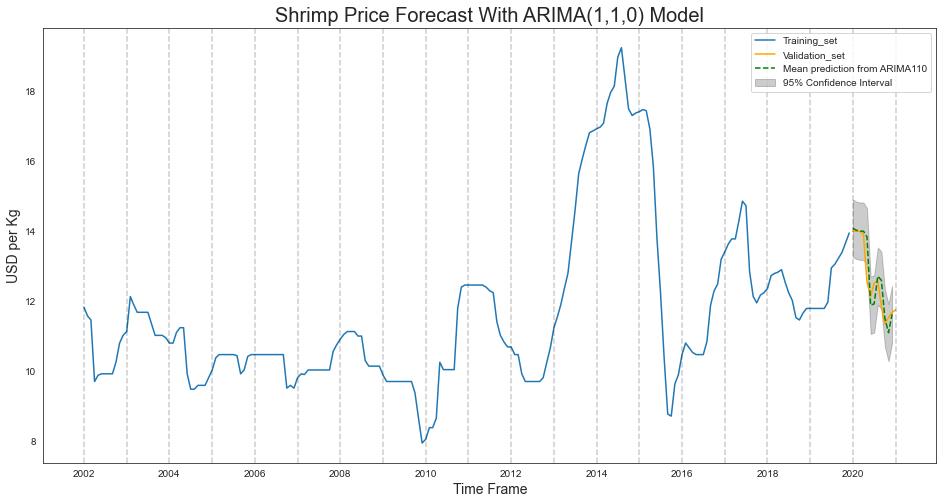

In [361]:
# Start date and End date
start_year = ts.index[0].year
end_year = ts.index[-1].year

# Setting figure
plt.figure(figsize=(16,8))
sns.set_style('white')

# plot data
plt.plot(train_ts.index,train_ts,label='Training_set')
plt.plot(val_ts.index,val_ts,label='Validation_set',color='orange')
plt.plot(prediction_rolling_df.index[-12:],prediction_rolling_df['mean'][-12:], label= 'Mean prediction from ARIMA110',color='green',alpha=2,linestyle='--')
plt.fill_between(prediction_rolling_df.index[-12:],
                 prediction_rolling_df.loc[:,'lower Price'][-12:],
                 prediction_rolling_df.loc[:,'upper Price'][-12:],
                 color='k',
                 alpha=0.2,
                 label='95% Confidence Interval')

# chart decoration
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.axvline(pd.to_datetime('2021'),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price Forecast With ARIMA(1,1,0) Model',fontsize=20)
plt.ylabel('USD per Kg',fontsize=14)
plt.xlabel('Time Frame',fontsize=14)
plt.legend(loc='upper right')
plt.show()

In [362]:
forecast_table = prediction_rolling_df.iloc[-12:,]
forecast_table['actual'] = val_ts
forecast_table = forecast_table.round(2)

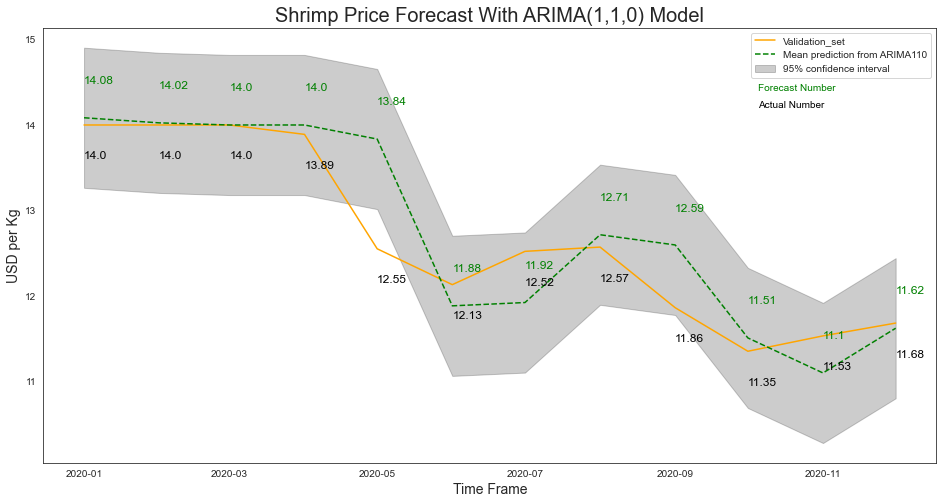

In [363]:
# Start date and End date
start_year = ts.index[0].year
end_year = ts.index[-1].year

# Setting figure
plt.figure(figsize=(16,8))
sns.set_style('white')

# plot data
plt.plot(val_ts.index[:-1],val_ts[:-1],label='Validation_set',color='orange')
plt.plot(prediction_rolling_df.index[-12:],prediction_rolling_df['mean'][-12:], label= 'Mean prediction from ARIMA110',color='green',alpha=2,linestyle='--')
plt.fill_between(prediction_rolling_df.index[-12:],
                 prediction_rolling_df.loc[:,'lower Price'][-12:],
                 prediction_rolling_df.loc[:,'upper Price'][-12:],
                 color='k',
                 alpha=0.2,
                 label='95% confidence interval')

# chart decoration
plt.title('Shrimp Price Forecast With ARIMA(1,1,0) Model',fontsize=20)
plt.ylabel('USD per Kg',fontsize=14)
plt.xlabel('Time Frame',fontsize=14)
plt.legend(loc='upper right')

# Text showing number
for i in forecast_table.index:
    plt.text(i,forecast_table.loc[i,'mean']+0.4,forecast_table.loc[i,'mean'],color='green',size=12) # show forecast number
    plt.text(i,forecast_table.loc[i,'actual']-0.4,forecast_table.loc[i,'actual'],color='black',alpha=2,size=12)
plt.text(pd.to_datetime('2020-10-5'),14.4,"Forecast Number",color='green')
plt.text(pd.to_datetime('2020-10-5'),14.2,"Actual Number",color='black')

plt.show()